In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Descriptors imported from RDKit (n=208)
all_descriptor_names = [desc[0] for desc in Descriptors._descList]   
calc = MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptor_names)

# Functions that calculate descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * len(all_descriptor_names)
    return calc.CalcDescriptors(mol)

#Check the validity of SMILES
def is_valid_molecule(smiles):
    return Chem.MolFromSmiles(smiles) is not None

In [6]:
# Loading data
df = pd.read_csv("DTB.csv") 
df = df.dropna(subset=["SMILES", "RI"])  
df = df[df["SMILES"].apply(is_valid_molecule)].copy() 

# Descriptors
df["Descriptors"] = df["SMILES"].apply(compute_descriptors)
desc_df = pd.DataFrame(df["Descriptors"].tolist(), columns=all_descriptor_names)
df = pd.concat([df.reset_index(drop=True), desc_df], axis=1)
df.drop(columns=["Descriptors"], inplace=True)

# Cleaning problematic columns
X = df[all_descriptor_names].replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=1)                        
X = X.loc[:, X.std() > 0]                 

filtered_descriptor_names = X.columns.tolist()
y = df["RI"].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nGeneral statistics :")
print(f"Total molecules in the database : {df.shape[0]} molecules")


General statistics :
Total molecules in the database : 166 molecules


In [4]:
# Definition of models
models = {"Linear": LinearRegression(), "Ridge": Ridge(alpha=1.0),"RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),"PLS": PLSRegression(n_components=5)}

k_values = list(range(5, 10)) + list(range(10, 161, 10))
results_all = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_k = selector.fit_transform(X_scaled, y)
    selected_indices = selector.get_support(indices=True)
    selected_names = [filtered_descriptor_names[i] for i in selected_indices]

    for name, model in models.items():
        # Cross-validation
        kf = KFold(n_splits=6, shuffle=True, random_state=42)
        r2_cv = cross_val_score(model, X_k, y, cv=kf, scoring='r2')

        # Internal split test
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Internal test metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        relative_error=np.abs((y_test - y_pred) / y_pred)*100
        rel_error = np.mean(relative_error) 


        results_all.append({
            "Model": name,
            "k": k,
            "MAE_test": mae,
            "R2_test": r2,
            "Relative_error (%)": rel_error,
            "R2_cv": r2_cv.mean()
        })

# Results
results_df = pd.DataFrame(results_all)
print(results_df.sort_values(by="R2_cv", ascending=False).head(5).to_string(index=False))

Model   k  MAE_test  R2_test  Relative_error (%)    R2_cv
Ridge 110 48.736690 0.980935            2.486368 0.983678
Ridge 100 51.086934 0.979838            2.653570 0.982099
Ridge  80 58.031055 0.974365            2.978162 0.981715
Ridge  90 55.534809 0.977101            2.859518 0.981529
Ridge 120 51.411666 0.980588            2.632438 0.980191


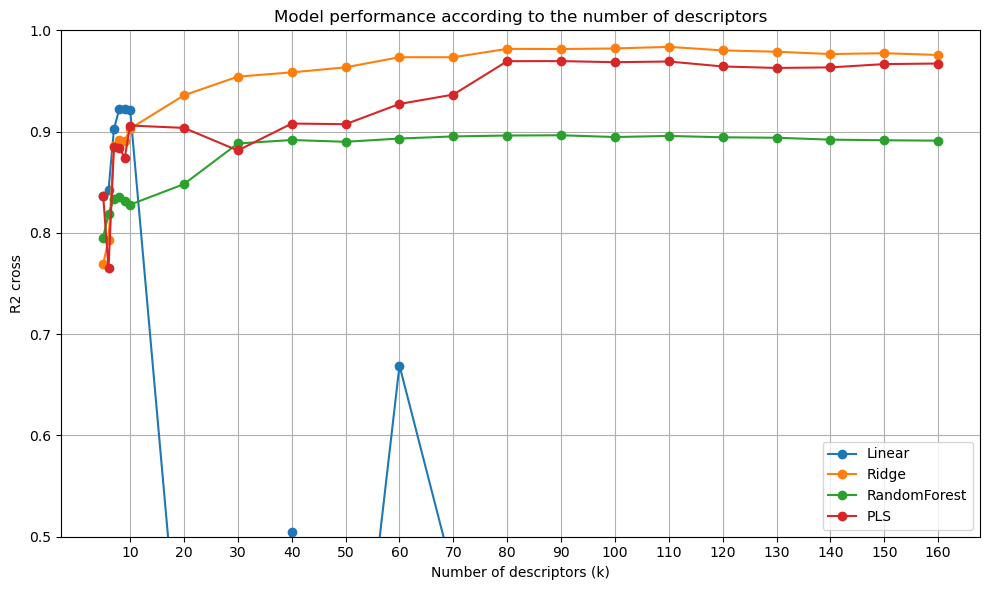

In [5]:
# R2_cv vs k curve for each model
plt.figure(figsize=(10, 6))
for model_name in models:
    model_data = results_df[results_df["Model"] == model_name]
    plt.plot(model_data["k"], model_data["R2_cv"],'o-',label=model_name)

plt.xlabel("Number of descriptors (k)")
plt.ylabel("R2 cross")
plt.title("Model performance according to the number of descriptors")
plt.legend()
plt.grid()
plt.ylim(0.5,1)
plt.xticks(ticks=range(10, 161, 10)) 
plt.tight_layout()
plt.show()